In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib import rcParams

In [3]:
N = 7
df = pd.read_csv(f'./data/connected-n{N}-results.csv')

In [47]:
# Bd temperature.
T = lambda G, v: sum(1/G.degree(u) for u in G.neighbors(v))/N

In [ ]:
G = nx.gnp_rand

In [25]:
ddf = df.groupby(by=['N', 'graph', 'r'])[['fix_time_temp', 'p_Bd']].apply(
  lambda x: x['fix_time_temp'].between(
    min(extrema := ((x[x['p_Bd'] == 0]['fix_time_temp'].iloc[0], x[x['p_Bd'] == 1]['fix_time_temp'].iloc[0]))) - 1e-5,
    max(extrema) + 1e-5,
  ).all()
).reset_index()
ddf[(ddf['r'] == 1) & (ddf[0] == False)]

,N,graph,r,0


In [ ]:
df

In [277]:
df['r'].unique()

array([0.25, 0.4 , 0.55, 0.7 , 0.85, 1.  , 1.15, 1.3 , 1.45, 1.6 , 1.75])

In [4]:
sns.set_theme(font_scale=2.5)
rcParams['font.family'] = 'sans-serif'
sns.set_style("ticks", {
  'axes.grid' : False,
  #   'axes.spines.left': False,
  'axes.spines.right': False,
  'axes.spines.top': False,
  #   'axes.spines.bottom': False,
})

In [29]:
# df = df.drop(columns=['temp_entropy'])
df.sample(n=1)

,Unnamed: 0,N,graph,p_Bd,r,fix_time_uniform,fix_prob_uniform,fix_time_temp,fix_prob_temp,fix_time_uniform_1,...,fix_time_uniform_5,fix_time_uniform_6,fix_time_uniform_7,fix_prob_uniform_1,fix_prob_uniform_2,fix_prob_uniform_3,fix_prob_uniform_4,fix_prob_uniform_5,fix_prob_uniform_6,fix_prob_uniform_7
79873,79873,7,46457a564f0a,0.2,0.4,31.072304,0.005335,30.984107,0.005401,29.557051,...,29.871768,32.17368,29.871768,0.006367,0.006367,0.002958,0.004475,0.006351,0.004475,0.006351


In [5]:
palette = sns.color_palette("colorblind")

In [45]:
def normalized_temperature_entropy(graph_hex: str):
  G = nx.graph6.from_graph6_bytes(
    bytes.fromhex(graph_hex).strip()
  )
  ts = np.array([T(G, v) for v in G.nodes()])
  ts = ts / ts.sum()
  return -np.sum(ts * np.log(ts)) / np.log(len(G))

  

In [48]:
# temperature_entropy(nx.graph6.to_graph6_bytes(nx.complete_graph(5)).hex())# '463f71726f0a')
df['normalized_temp_entropy'] = df['graph'].apply(normalized_temperature_entropy)

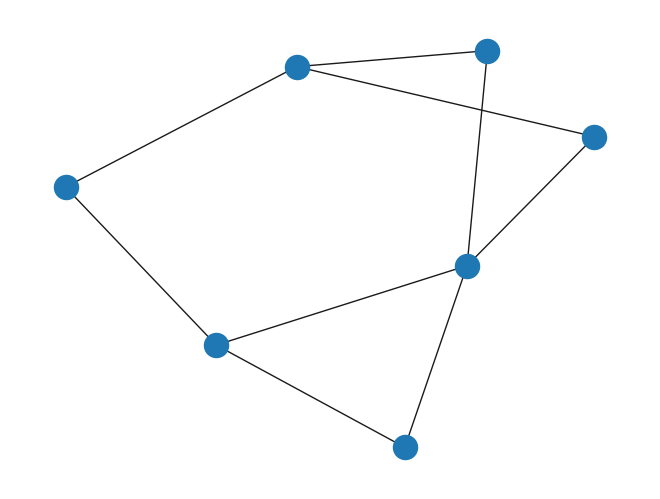

In [ ]:
df['interpolated_fix_prob_temp'] = df['p_Bd'] * df['fix_prob_temp']
df.groupby(by=['graph', 'r', 'p_Bd']).agg(
  interpolated_fix_prob_temp=('p_Bd', lambda x: x * ),
).reset_index()

In [133]:
sorted(df.r.unique())

[np.float64(0.25),
 np.float64(0.4),
 np.float64(0.55),
 np.float64(0.7),
 np.float64(0.85),
 np.float64(1.0),
 np.float64(1.15),
 np.float64(1.3),
 np.float64(1.45),
 np.float64(1.6),
 np.float64(1.75)]

In [250]:
optimum_df = df[['p_Bd', 'fix_prob_temp', 'r', 'graph']].groupby(by=['graph', 'r']).agg(
  min_fp=('fix_prob_temp', lambda x: x.min()),
  max_fp=('fix_prob_temp', lambda x: x.max()),
).reset_index().sort_values(by=['graph', 'r'])

Text(52.75, 0.5, 'Maximum fixation probability, $\\mathrm{fp_{\\mathrm{max}}}$')

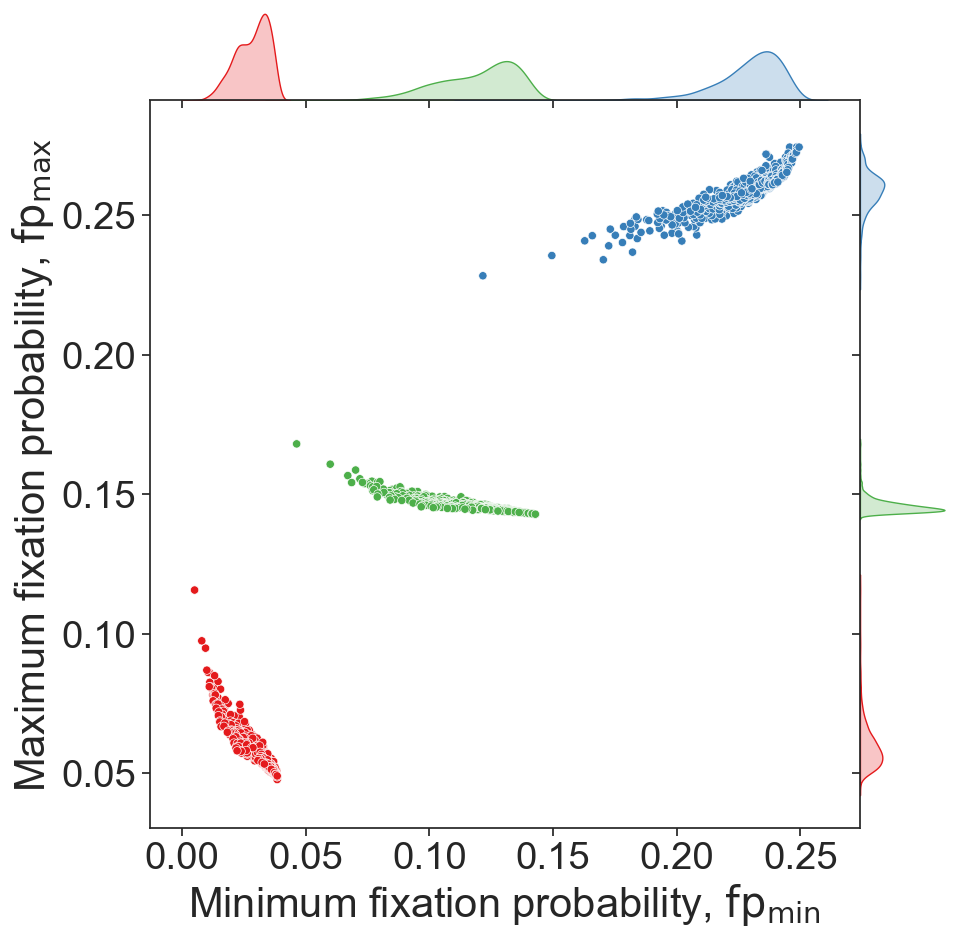

In [295]:
g = sns.jointplot(
  data=optimum_df[(optimum_df['r'] == 1) | (optimum_df['r'] == 1.3) | (optimum_df['r'] == 0.7)],
  x='min_fp',
  y='max_fp',
  hue='r',
  hue_order=[.7, 1.3, 1],
  legend=False,
  height=10,
  ratio=8,
  space=0,
  palette='Set1',
  #s=10,
  # hue='r',
  # palette=palette,
  # s=100,
  # alpha=0.8,
  # edgecolor='black',
  # linewidth=0.5,
  # marker='o',
)
plt.xlabel('Minimum fixation probability, $\\mathrm{fp_{\\mathrm{min}}}$')
plt.ylabel('Maximum fixation probability, $\\mathrm{fp_{\\mathrm{max}}}$')
# .plot_joint(
 #  sns.kdeplot,
 #  zorder=0,
 #  fill=True,
 #  thresh=0.1,
 #  cmap=sns.cubehelix_palette(light=1, as_cmap=True),
 #  legend=False,
 #  cbar=False,
 #  cbar_kws={},
#)

In [296]:
g.figure.savefig(
  f'/Users/david/Dropbox/David B/Mixed Moran/Pretty Figures/2-fpmin-vs-fpmax.png',
  bbox_inches='tight',
  dpi=300,
)

KeyError: 'normalized_temp_entropy'

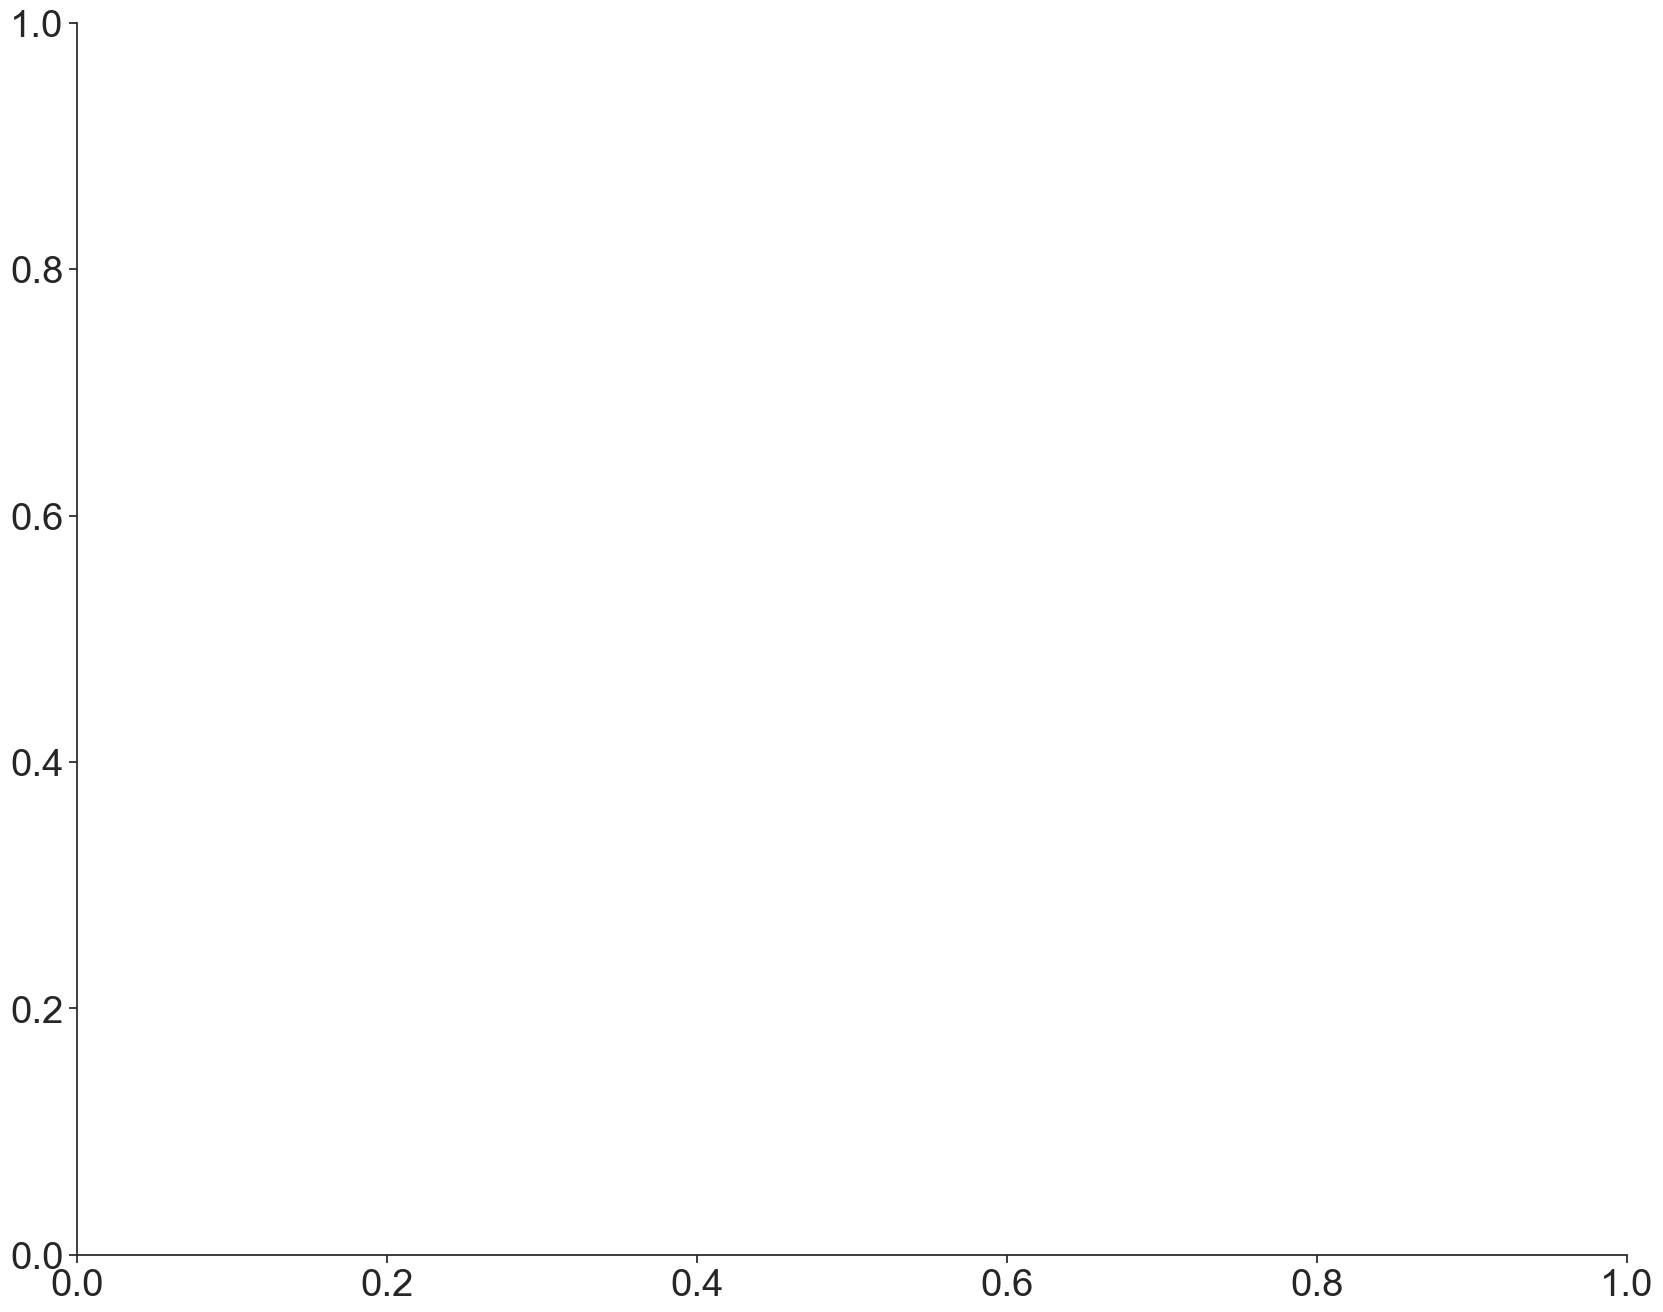

In [30]:
fig, ax = plt.subplots(figsize=(20, 16))
palettes = [
    sns.color_palette(color, as_cmap=True)
    for color in ('Reds', 'Greens', 'Blues')
]
for R, palette in zip((.7, 1, 1.3), palettes):
    sub_df = df[df['r'] == R].sort_values(by=['normalized_temp_entropy'], ascending=False)
    colors = [palette(normalized_temperature_entropy(G_hex)) for G_hex in sub_df['graph'].unique()]
    g = sns.lineplot(
        data=sub_df,
        x='p_Bd',
        y='fix_prob_temp',
        hue='graph',
        palette=colors,
        legend=False,
        alpha=0.5,
        lw=2,
        ax=ax,
    )
    g.set(
        xlabel='Probability of Birth-death step, $p_{\\text{Bd}}$',
        ylabel='Fixation probability, fp',
        ylim=(0, .3),
    )

norm = plt.Normalize(0, 1)
for colorbar_idx, palette in enumerate(palettes):
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    g.figure.colorbar(
        sm,
        ax=plt.gca(),
        label='Normalized temperature entropy' if colorbar_idx == 0 else None,
        ticks=[0, 1] if colorbar_idx == 0 else [],
        pad={0: -0.105, 1: -.101, 2: 0}[colorbar_idx],
    )
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
# g.figure.savefig(
#   f'/Users/david/Dropbox/David B/Mixed Moran/Pretty Figures/2-ft-vs-pbd-n{N}-r{R}.png',
#   bbox_inches='tight',
#   transparent=True,
#   dpi=300,
# )

In [240]:
g.figure.savefig(
  f'/Users/david/Dropbox/David B/Mixed Moran/Pretty Figures/2-fp-vs-pbd-n{N}.png',
  bbox_inches='tight',
  dpi=300,
)

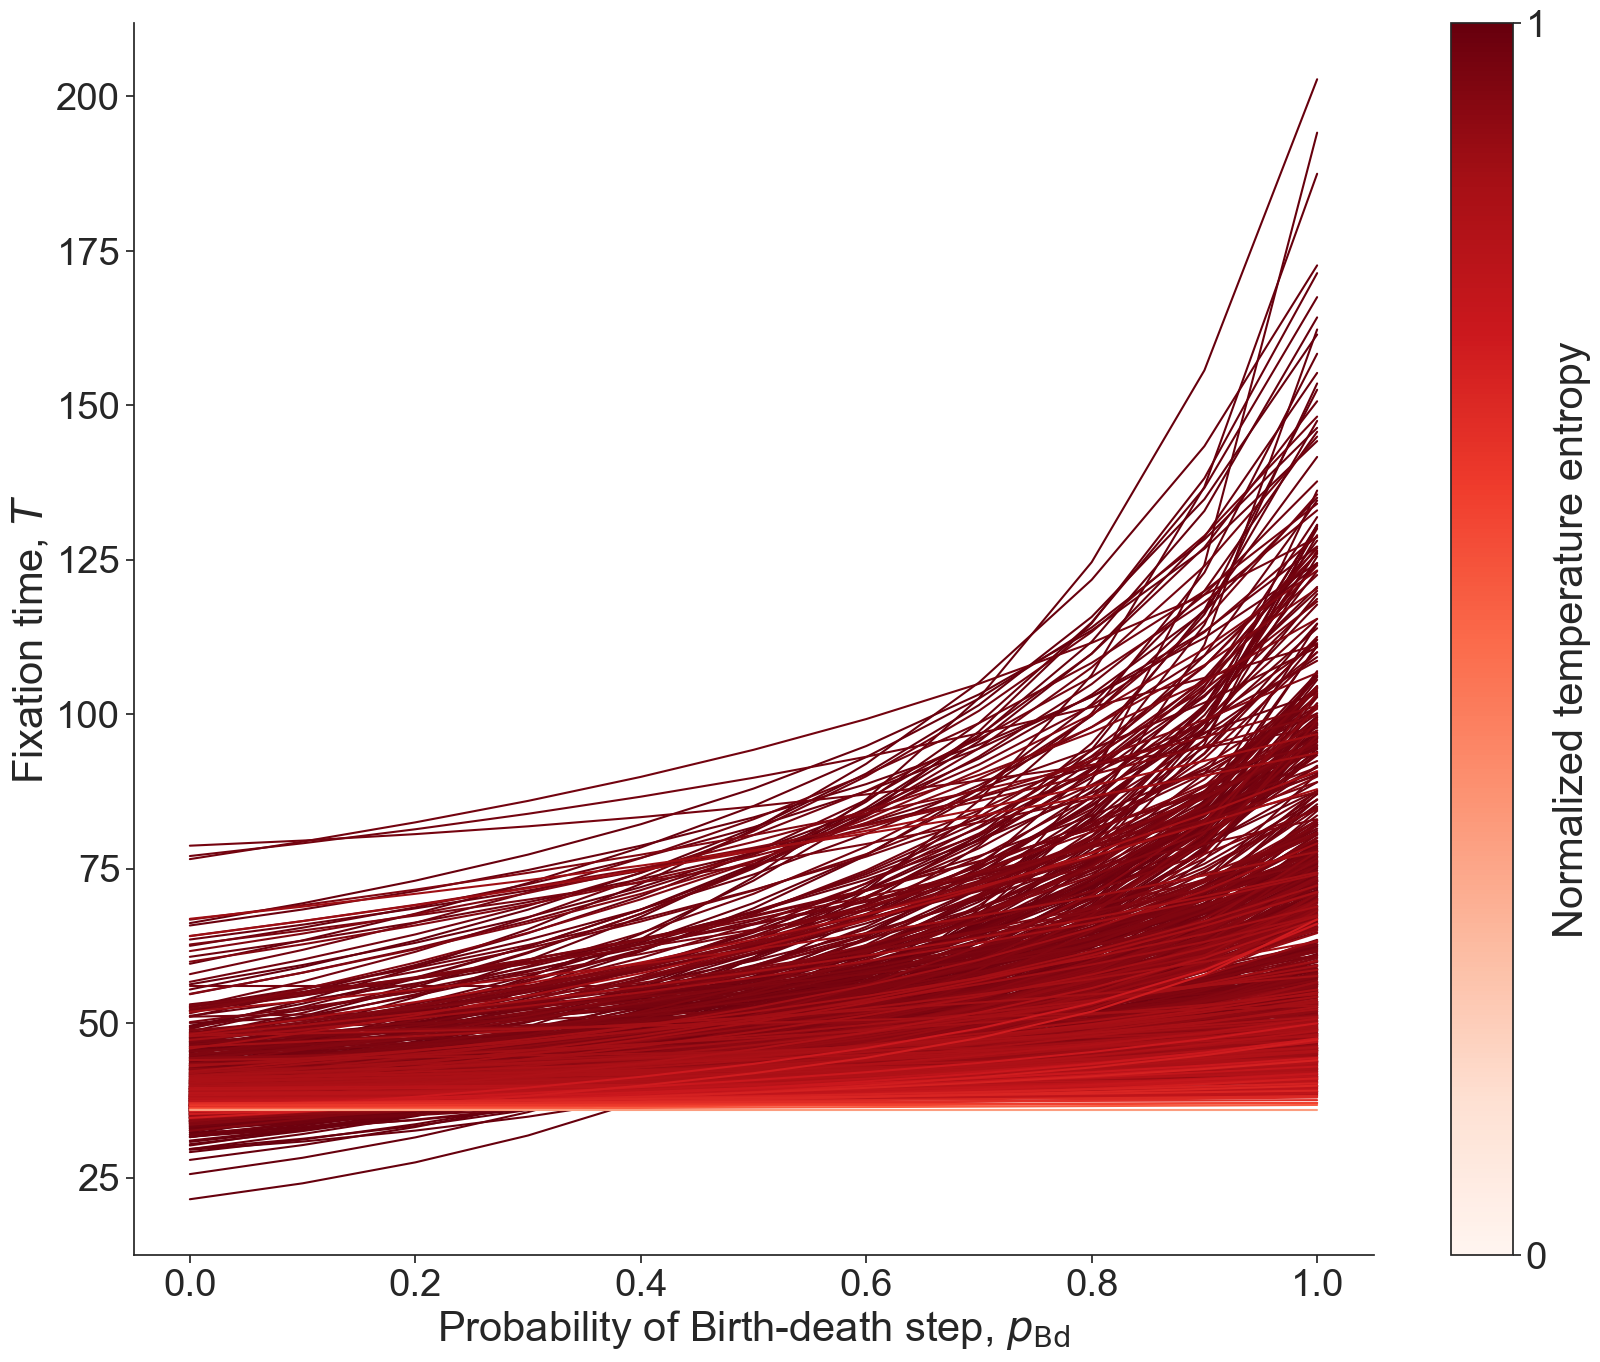

In [57]:
fig, ax = plt.subplots(figsize=(20, 16))
palette = sns.color_palette('Reds', as_cmap=True)
# sub_df = df.sort_values(by=['normalized_temp_entropy'], ascending=False)
# palettes = [
#     sns.color_palette(color, as_cmap=True)
#     for color in ('Reds', 'Greens', 'Blues')
# ]
# for palette, r in zip(palettes, (.7, 1, 1.3)):
colors = [palette(normalized_temperature_entropy(G_hex)) for G_hex in sub_df['graph'].unique()]
g = sns.lineplot(
    data=(ssub_df:=df[(df['r'] == 1)]), #& (df['graph'] == '46557a726f0a')]),
    x='p_Bd',
    y='fix_time_uniform',
    hue='graph',
    palette=colors,# 'Set1', #[palette[0]],
    # legend=False,
    # alpha=0.5,
    legend=False,
    # lw=2,
    ax=ax,
)
g.set(
    xlabel='Probability of Birth-death step, $p_{\\text{Bd}}$',
    ylabel='Fixation time, $T$',
    # ylim=(0, 200),
    # xticklabels=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
    # xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
)
# sns.pointplot(
#   x='p_Bd',
#   y='fix_time_temp',
#   hue='r',
#   palette=[palette[0], palette[2], palette[1]],
#   data=sub_df,
#   estimator=np.median,
#   legend=False,
#   ax=ax,
# )

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
g.figure.colorbar(
    sm,
    ax=plt.gca(),
    label='Normalized temperature entropy',
    ticks=[0, 1],# if colorbar_idx == 0 else [],
    # pad={0: -0.105, 1: -.101, 2: 0}[colorbar_idx],
)
# for colorbar_idx, palette in enumerate(palettes):
#     sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
#     g.figure.colorbar(
#         sm,
#         ax=plt.gca(),
#         label='Normalized temperature entropy' if colorbar_idx == 0 else None,
#         ticks=[0, 1],# if colorbar_idx == 0 else [],
#         # pad={0: -0.105, 1: -.101, 2: 0}[colorbar_idx],
#     )

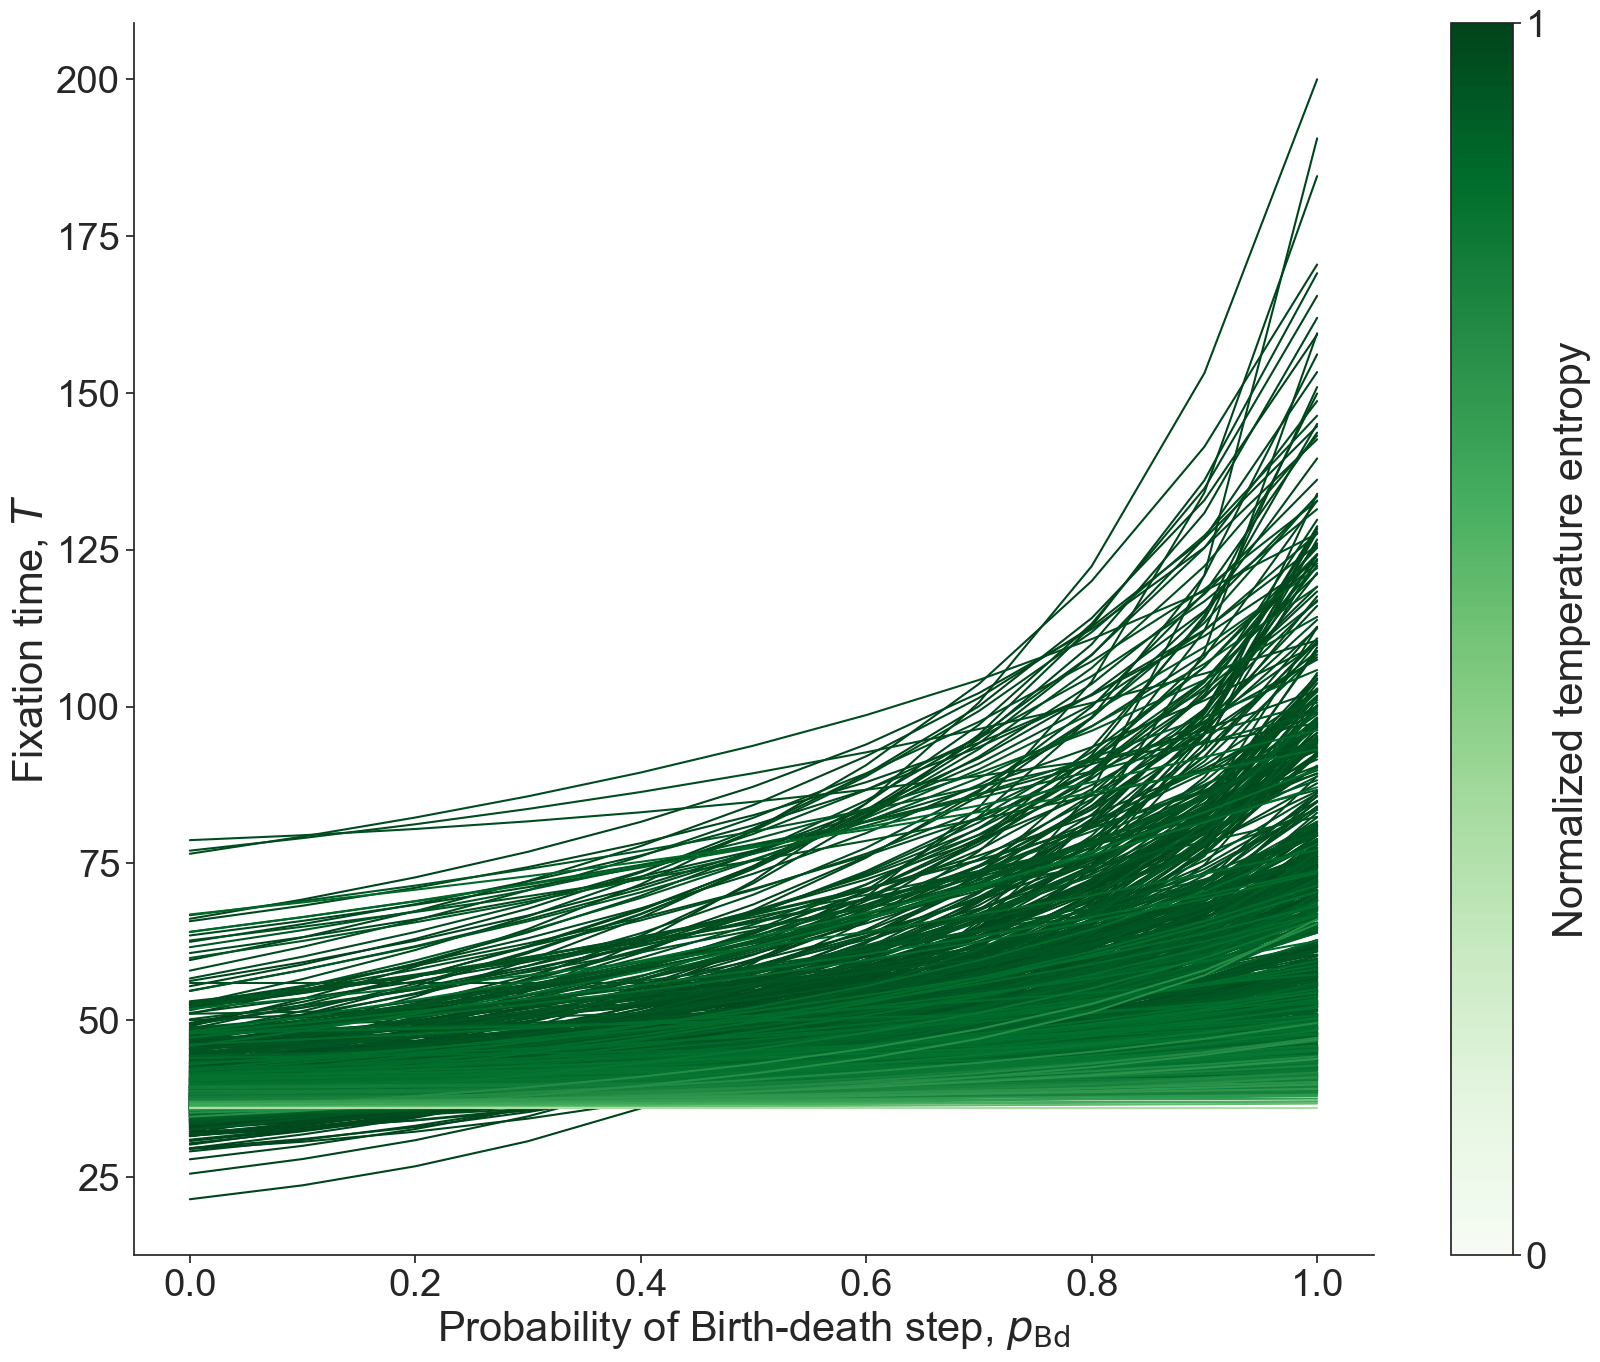

In [ ]:
fig, ax = plt.subplots(figsize=(20, 16))
palette = sns.color_palette('Greens', as_cmap=True)
# sub_df = df.sort_values(by=['normalized_temp_entropy'], ascending=False)
# palettes = [
#     sns.color_palette(color, as_cmap=True)
#     for color in ('Reds', 'Greens', 'Blues')
# ]
# for palette, r in zip(palettes, (.7, 1, 1.3)):
colors = [palette(normalized_temperature_entropy(G_hex)) for G_hex in sub_df['graph'].unique()]
g = sns.lineplot(
    data=(ssub_df:=df[(df['r'] == 1)]), #& (df['graph'] == '46557a726f0a')]),
    x='p_Bd',
    y='fix_time_temp',
    hue='graph',
    palette=colors,# 'Set1', #[palette[0]],
    # legend=False,
    # alpha=0.5,
    legend=False,
    # lw=2,
    ax=ax,
)
g.set(
    xlabel='Probability of Birth-death step, $p_{\\text{Bd}}$',
    ylabel='Fixation time, $T$',
    # ylim=(0, 200),
    # xticklabels=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
    # xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
)
# sns.pointplot(
#   x='p_Bd',
#   y='fix_time_temp',
#   hue='r',
#   palette=[palette[0], palette[2], palette[1]],
#   data=sub_df,
#   estimator=np.median,
#   legend=False,
#   ax=ax,
# )

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
g.figure.colorbar(
    sm,
    ax=plt.gca(),
    label='Normalized temperature entropy',
    ticks=[0, 1],# if colorbar_idx == 0 else [],
    # pad={0: -0.105, 1: -.101, 2: 0}[colorbar_idx],
)
# for colorbar_idx, palette in enumerate(palettes):
#     sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
#     g.figure.colorbar(
#         sm,
#         ax=plt.gca(),
#         label='Normalized temperature entropy' if colorbar_idx == 0 else None,
#         ticks=[0, 1],# if colorbar_idx == 0 else [],
#         # pad={0: -0.105, 1: -.101, 2: 0}[colorbar_idx],
#     )

In [84]:
ssdf = df[['fix_time_temp', 'fix_time_uniform', 'graph', 'r', 'p_Bd']]
ssdf[(ssdf['graph'] == '463f3f46770a') & (ssdf['r'] == 1)]
# ssdf[ssdf['fix_time_temp'].min() == ssdf['fix_time_temp']]


,fix_time_temp,fix_time_uniform,graph,r,p_Bd
55,21.485714,21.485714,463f3f46770a,1.0,0.0
56,23.706941,24.064084,463f3f46770a,1.0,0.1
57,26.742017,27.456303,463f3f46770a,1.0,0.2
58,30.734799,31.806227,463f3f46770a,1.0,0.3
59,35.966234,37.394805,463f3f46770a,1.0,0.4
60,42.914286,44.700000,463f3f46770a,1.0,0.5
61,52.398413,54.541270,463f3f46770a,1.0,0.6
62,65.909443,68.409443,463f3f46770a,1.0,0.7
63,86.441071,89.298214,463f3f46770a,1.0,0.8
64,120.988820,124.203106,463f3f46770a,1.0,0.9


467361433f0a


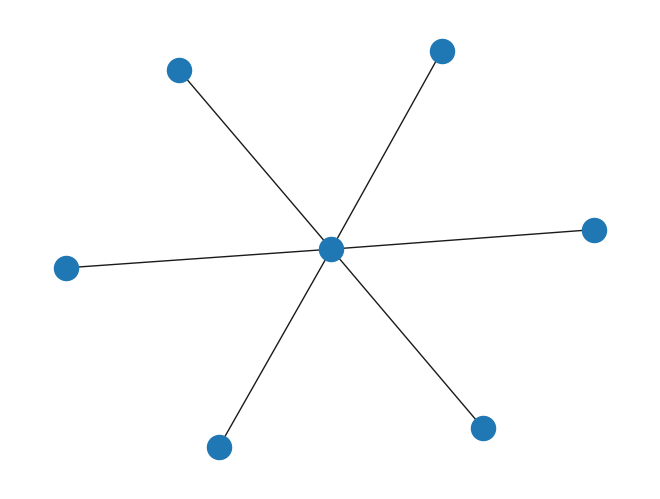

In [75]:
G = nx.star_graph(6)
print(nx.graph6.to_graph6_bytes(G, header=False).hex())
nx.draw(G)

In [334]:
g.figure.savefig(
  f'/Users/david/Dropbox/David B/Mixed Moran/Pretty Figures/3-ft-vs-pbd-n{N}.png',
  bbox_inches='tight',
  dpi=300,
)

In [13]:
glue_df = sns.load_dataset("glue")

In [15]:
glue_df[glue_df['Model'] == 'BERT']

,Model,Year,Encoder,Task,Score
3,BERT,2018,Transformer,CoLA,60.5
11,BERT,2018,Transformer,SST-2,94.9
19,BERT,2018,Transformer,MRPC,89.3
27,BERT,2018,Transformer,STS-B,87.6
35,BERT,2018,Transformer,QQP,72.1
43,BERT,2018,Transformer,MNLI,86.7
51,BERT,2018,Transformer,QNLI,92.7
59,BERT,2018,Transformer,RTE,70.1


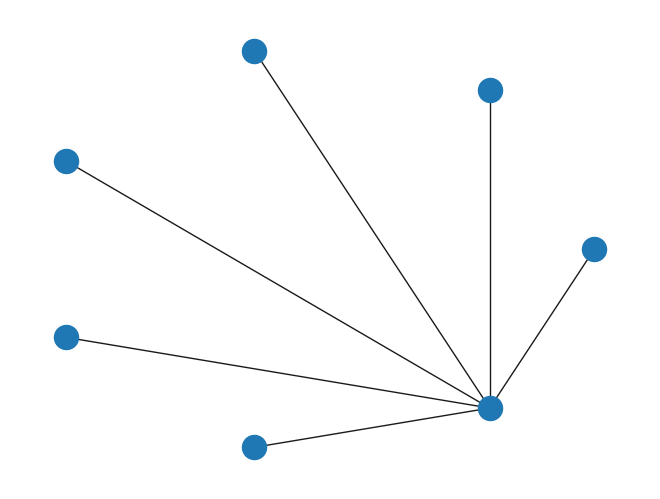

In [82]:
G = nx.graph6.from_graph6_bytes(bytes.fromhex('463f3f46770a').strip())
nx.draw(G, pos=nx.circular_layout(G), with_labels=False)